# A/B/n testing using online advertising scenario

Consider a company that wants to advertise a product on various websites through digital banners, aiming to attract visitors to the product landing page. Among multiple alternatives, the advertiser company wants to find out which banner is the most effective and has the maximum **click-through rate (CTR)**, which is defined as the total number of clicks an ad receives divided by the total number of impressions (number of times it is shown).

Every time a banner is about to be shown on a website, it is the advertiser's algorithm that chooses the banner (for example, through an API provided by the advertiser to the website) and observes whether the impression has resulted in a click or not. This is a great use case for a MAB model, which could boost clicks and product sales. What we want the MAB model to do is toidentify the ad that performs the best as early as possible, display it more, and write off the ad(s) that is (are) a clear loser(s) as early as possible.

:::{tip}
The probability of observing a click or no click after an impression, a binary outcome, can be modeled using the Bernoulli distribution. It has a single parameter, , which is the probability of receiving a click, or more generally, observing a 1 as opposed to a 0. Note that this is a discrete probability distribution, whereas the normal distribution we used earlier is a continuous one.
:::

In the [previous page](mab-code.ipynb), we had rewards coming from a normal (Gaussian) distribution. In the online ad case, we have a binary outcome. For each ad version, there is a different probability of click (CTR), which the advertiser does not know but is trying to discover. So, the rewards will come from different **Bernoulli distributions** for each ad. Let's code these to use with our algorithms later:

**1. We start by creating a class to model the ad behavior:**

In [1]:
import numpy as np

class BernoulliBandit(object):
    def __init__(self, p):
        self.p = p
    
    def display_ad(self):
        reward = np.random.binomial(n=1, p=self.p)
        return reward

**2. Now, let's create five different ads (banners) with the corresponding CTRs we arbitrarily pick:**

In [2]:
adA = BernoulliBandit(0.004)
adB = BernoulliBandit(0.016)
adC = BernoulliBandit(0.02)
adD = BernoulliBandit(0.028)
adE = BernoulliBandit(0.031)

ads = [adA, adB, adC, adD, adE]

Let's code exploration strategy for the above ads and try to estimate the probabilities of reward for each online ad.

# A/B/n testing

One of the most common exploration strategies is what is called A/B testing, which is a method to determine which one of the two alternatives (of online products, pages, ads, and so on) performs better. In this type of testing, the users are randomly split into two groups to try different alternatives. At the end of the testing period, the results are compared to choose the best alternative, which is then used in production for the rest of the problem horizon. In our case, we have more than two ad versions. So, we will implement what is called A/B/n testing.

We will use A/B/n testing as our baseline strategy for comparison with the more advanced methods that we will introduce afterward. Before going into the implementation, we need to define some notation that we will use throughout the chapter.

## Notation

Throughout the implementations of various algorithms, we will need to keep track of some quantities related to a particular action (the ad chosen for display), $a$. Now, we define some notation for those quantities. Initially, we drop $a$ from our notation for brevity, but at the end of this section, we will put it back:

* First, we denote the reward (that is, 1 for a click, 0 for no click) received after selecting the action, $a$, for the $i^{th}$ time by $R_i$.

* The average reward observed before the $n^{th}$ selection of this same action is defined as follows:

$$Q_n = \frac{R_1 + R_2 + R_3 + ... + R_{n-1}}{n-1}$$

This estimates the expected value of the reward that this action yields, $R$, after $n-1$ observations.

* This is also called the **action value** of $a$. Here, $Q_n$ estimates of the action value after selecting this action $n-1$ times.

* Using simple algebra we can modify the above formula for $Q_n$ into a more convenient form.

$$\begin{align}
Q_{n+1} &= \frac{R_1 + R_2 + R_3 + ... + R_{n}}{n} \\
&= \frac{R_1 + R_2 + R_3 + ... + R_{n-1}}{n-1} + \frac{R_n}{n} \\
&= \frac{n-1}{n}\cdot Q_n + \frac{R_n}{n} \\
&= Q_n + \frac{1}{n}\cdot (R_n-Q_n)
\end{align}$$

* Remember that $Q_n$ is our estimate for the action value of $a$ before we take it for the $n^{th}$ time. When we observe the reward, $R_n$, it gives us another signal for the action value. We don't want to discard our previous observations, but we also want to update our estimate to reflect the new signal.

* This means, we adjust our current estimate, $Q_n$, in the direction of the **error** that we calculate based on the latest observed reward, $R_n - Q_n$, with a **step size** of $1/n$ and obtain a new estimate, $Q_{n+1}$. This means, for example, if the latest observed reward is greater than our current estimate, we revise the action value estimate upward.

* For convenience, we define $Q_0 = 0$.

* Notice that the rate at which we adjust our estimate will get smaller as we make more observations due to the $1/n$ term. So, we put less weight on the most recent observations and our estimate for the action value for a particular action will settle down over time.

* However, this might be a disadvantage if the environment is not stationary but is changing over time. In those cases, we would want to use a step size that does not diminish over time, such as a fixed step size of $\alpha \in (0,1)$.

* Note that this step size must be smaller than 1 for the estimate to converge (and larger than 0 for a proper update).

* Using a fixed value for $\alpha$ will make the weights of the older observations decrease exponentially as we take action $\alpha$ more and more.

Let's bring $\alpha$ back to the notation, so we can obtain our formula to update the action values:

$$
Q_{n+1}(a) = Q_n(a) + \alpha (R_n(\alpha) - Q_n(a))
$$

Here, is a number between 0 and 1. For stationary problems, we usually set $\alpha = 1/N(a)$, where $N(a)$ is the number of times the action $a$ has been taken up to that point (which was denoted by $n$ initially). In stationary problems, this will help action values converge quicker, due to the diminishing $1/N(a)$ term, rather than chasing after noisy observations.

That's all we need. Without further ado, let's implement an A/B/n test.

## Application to the online advertising scenario

In our example, we have five different ad versions, which we randomly show to the users with equal probabilities. Let's implement this in Python:

**1. We start with creating the variables to keep track of the rewards in the experiment:**

In [3]:
n_test = 10000
n_prod = 90000
n_ads = len(ads)
Q = np.zeros(n_ads)  # Q, action values
N = np.zeros(n_ads)  # N, total impressions
total_reward = 0
avg_rewards = []  # Save average rewards over time

In [4]:
# A/B/n test
for i in range(n_test):
    ad_chosen = np.random.randint(n_ads)
    R = ads[ad_chosen].display_ad()  # Observe reward
    N[ad_chosen] += 1
    Q[ad_chosen] += (1 / N[ad_chosen]) * (R - Q[ad_chosen])
    total_reward += R
    avg_reward_so_far = total_reward / (i + 1)
    avg_rewards.append(avg_reward_so_far)

In [5]:
best_ad_index = np.argmax(Q)  # Find the best action
print("The best performing ad is {}".format(chr(ord('A') + best_ad_index)))

The best performing ad is D


In [6]:
ad_chosen = best_ad_index
for i in range(n_prod):
    R = ads[ad_chosen].display_ad()
    total_reward += R
    avg_reward_so_far = total_reward / (n_test + i + 1)
    avg_rewards.append(avg_reward_so_far)

In [7]:
import pandas as pd
df_reward_comparison = pd.DataFrame(avg_rewards, columns=['A/B/n'])

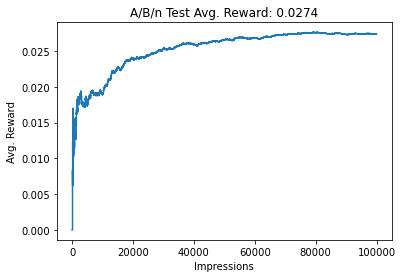

In [8]:
import matplotlib.pyplot as plt

df_reward_comparison['A/B/n'].plot(title="A/B/n Test Avg. Reward: {:.4f}"
                                    .format(avg_reward_so_far))
plt.xlabel("Impressions")
plt.ylabel("Avg. Reward")
plt.show()

In [9]:
print(Q)

# Actual probabilities of rewards
# adA = BernoulliBandit(0.004)
# adB = BernoulliBandit(0.016)
# adC = BernoulliBandit(0.02)
# adD = BernoulliBandit(0.028)
# adE = BernoulliBandit(0.031)

[0.00462963 0.01318359 0.01942231 0.0332829  0.02379772]


The model explores for the first 10000 steps. Once the estimated rewards for each ad are updated, the model picks the ad with highest estimated probability is shown for the next 90000 impressions to receive reward.

It can be seen that the overall average reward for all the impressions converges with the actual reward for the add E

# Advantages and disadvantages of A/B/n testing

* **A/B/n testing is inefficient as it does not modify the experiment dynamically by learning from the observations**. Instead, it explores in a fixed time budget with pre-determined probabilities of trying the alternatives. It fails to benefit from the early observations in the test by writing off/promoting an alternative even though it is obviously underperforming/outperforming the others.

* **It is unable to correct a decision once it's made**. If, for some reason, the test period identifies an alternative as the best incorrectly (mostly because of a not-sufficiently long test duration), this selection remains fixed during the production period. So, there is no way to correct the decision for the rest of the deployment horizon.

* **It is unable to adapt to changes in a dynamic environment**. Related to the previous note, this approach is especially problematic for environments that are not stationary. So, if the underlying reward distributions change over time, plain A/B/n testing has no way of detecting such changes after the selection is fixed.

* **The length of the test period is a hyperparameter to tune, affecting the efficiency of the test**. If this period is chosen to be shorter than needed, an incorrect alternative could be declared the best because of the noise in the observations. If the test period is chosen to be too long, too much money gets wasted in exploration.

* **A/B/n testing is simple**. Despite all these shortcomings, it is intuitive and easy to implement, and therefore widely used in practice.

So, the vanilla A/B/n testing is a rather naive approach to MAB. Next, let's look into some other more advanced approaches that will overcome some of the shortcomings of A/B/n testing, starting with ε-greedy.

# References

* https://www.packtpub.com/product/mastering-reinforcement-learning-with-python/9781838644147

_This entire page is a chapter referenced from the above link. EssentialAI does not claim ownership of the content in any way._